In [1]:
import torch.nn as nn
import torch
import os
import matplotlib.pyplot as plt

from train import load_data, train, eval
from models import *
import json
import argparse
from loss import leakage_loss, leakage_loss_simple
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class SyntheticDataset(torch.utils.data.Dataset):
    def __init__(self, data_fn, x_num, c_num, y_num):
        self.data = torch.load(data_fn, weights_only=True)
        self.x_num = x_num
        self.c_num = c_num
        self.y_num = y_num

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx,:self.x_num].float(), self.data[idx,-self.c_num:], self.data[idx,self.x_num]
    

class BinarySigmoid(nn.Module):
    def __init__(self):
        super(BinarySigmoid, self).__init__()

    def forward(self, x):
        return torch.round(torch.nn.functional.sigmoid(x))

In [3]:
data_fn = 'data/covertype_concepts.pkl'
x_num = 54
c_num = 32
y_num = 7
l_num = 0
batch_size = 2048*4
lr=0.001
y_weight = 1
c_weight = 1
l_weight = 1/20
epochs = 50

xc_depth = 2
xc_width = 512
xc_use_relu = True
xc_use_sigmoid = False
xc_final_activation = BinarySigmoid()

cy_depth = 2
cy_width = 512
cy_use_relu = True
cy_use_sigmoid = False
cy_final_activation = nn.Softmax(dim=1)

In [4]:
# Loading the Data
dataset = SyntheticDataset(data_fn, x_num, c_num, y_num)
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [5]:
x_to_c_model = XtoCModel(x_num, c_num, l_num, depth=xc_depth, width=xc_width,
                         use_relu=xc_use_relu, use_sigmoid=xc_use_sigmoid, 
                         final_activation=xc_final_activation).to(device)
c_to_y_model = CtoYModel(c_num+l_num, y_num, depth=cy_depth, width=cy_width,
                         use_relu=cy_use_relu, use_sigmoid=cy_use_sigmoid, 
                         final_activation=cy_final_activation).to(device)
model = FullModel(x_to_c_model, c_to_y_model).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
y_criterion = nn.CrossEntropyLoss()
c_criterion = nn.BCELoss()
l_criterion = None
print(model)

FullModel(
  (x_to_c_model): XtoCModel(
    (activation_func): ReLU()
    (linears): ModuleList(
      (0): Linear(in_features=54, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=32, bias=True)
    )
    (final_activation): BinarySigmoid()
  )
  (c_to_y_model): CtoYModel(
    (activation_func): ReLU()
    (linears): ModuleList(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=7, bias=True)
    )
    (final_activation): Softmax(dim=1)
  )
)


In [6]:
losses, accuracies, concept_accuracy = train(model, train_loader, c_num, optimizer, y_criterion=y_criterion,
            concept_criterion=c_criterion, y_weight=y_weight, concept_weight=c_weight, 
            latent_weight=l_weight, latent_criterion=l_criterion, epochs=epochs, device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor([0.4799, 0.7056, 0.5791, 0.6896, 0.4335, 0.8112, 0.1128, 0.5695, 0.9592,
        0.1561, 0.0267, 0.5701, 0.9512, 0.1147, 0.5522, 0.0920, 0.5835, 0.6108,
        0.0305, 0.1346, 0.2649, 0.9033, 0.7333, 0.2465, 0.9338, 0.5752, 0.6580,
        0.8065, 0.8226, 0.6240, 0.8734, 0.6583], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4792, 0.7026, 0.5746, 0.6957, 0.4415, 0.8018, 0.1123, 0.5631, 0.9579,
        0.1549, 0.0278, 0.5723, 0.9489, 0.1130, 0.5475, 0.0905, 0.5751, 0.6094,
        0.0292, 0.1421, 0.2629, 0.9075, 0.7252, 0.2493, 0.9355, 0.5649, 0.6591,
        0.7972, 0.8313, 0.6306, 0.8767, 0.6556], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4845, 0.7069, 0.5690, 0.6929, 0.4415, 0.8054, 0.1036, 0.5726, 0.9575,
        0.1624, 0.0261, 0.5555, 0.9508, 0.1134, 0.5521, 0.0885, 0.5769, 0.6122,
        0.0302, 0.1456, 0.2589, 0.9156, 0.7294, 0.2484, 0.9309, 0.5831, 0.6519,
        0.8079, 0.8239, 0.6185, 0.8756, 0.6477], device='cuda:0',
       grad_fn=<Me

  2%|▏         | 1/50 [00:01<00:54,  1.11s/it]

tensor([0.4792, 0.7069, 0.5697, 0.6842, 0.4331, 0.8049, 0.1042, 0.5720, 0.9598,
        0.1582, 0.0266, 0.5691, 0.9481, 0.1210, 0.5479, 0.0818, 0.5783, 0.6173,
        0.0279, 0.1409, 0.2623, 0.9061, 0.7242, 0.2620, 0.9327, 0.5793, 0.6659,
        0.7888, 0.8229, 0.6262, 0.8840, 0.6533], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.9346 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4789, 0.7112, 0.5768, 0.6877, 0.4349, 0.8020, 0.1105, 0.5785, 0.9595,
        0.1537, 0.0254, 0.5659, 0.9507, 0.1129, 0.5513, 0.0868, 0.5802, 0.6111,
        0.0305, 0.1388, 0.2670, 0.9075, 0.7355, 0.2531, 0.9349, 0.5765, 0.6626,
        0.8010, 0.8223, 0.6270, 0.8737, 0.6584], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4827, 0.7067, 0.5731, 0.6914, 0.4390, 0.8088, 0.1056, 0.5542, 0.9586,
        0.1572, 0.0271, 0.5726, 0.9504, 0.1140, 0.5511, 0.0934, 0.5731, 0.6150,
        0.0299, 0.1377, 0.2526, 0.9094, 0.7261, 0.2550, 0.9364, 0.5721, 0.6541,
        0.7997, 0.8269,

  4%|▍         | 2/50 [00:01<00:40,  1.18it/s]

tensor([0.4781, 0.7015, 0.5789, 0.6906, 0.4418, 0.8020, 0.1068, 0.5718, 0.9579,
        0.1583, 0.0278, 0.5620, 0.9484, 0.1160, 0.5504, 0.0846, 0.5785, 0.6101,
        0.0300, 0.1449, 0.2694, 0.9067, 0.7314, 0.2421, 0.9308, 0.5734, 0.6602,
        0.7983, 0.8247, 0.6149, 0.8802, 0.6531], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4842, 0.7014, 0.5619, 0.6949, 0.4342, 0.8119, 0.1117, 0.5730, 0.9581,
        0.1635, 0.0271, 0.5656, 0.9499, 0.1188, 0.5466, 0.0897, 0.5829, 0.6125,
        0.0271, 0.1422, 0.2595, 0.9097, 0.7176, 0.2543, 0.9304, 0.5809, 0.6558,
        0.8049, 0.8279, 0.6261, 0.8791, 0.6476], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.9056 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4867, 0.7102, 0.5742, 0.6882, 0.4358, 0.8074, 0.1042, 0.5673, 0.9559,
        0.1602, 0.0292, 0.5750, 0.9492, 0.1132, 0.5526, 0.0870, 0.5786, 0.6106,
        0.0308, 0.1448, 0.2566, 0.9102, 0.7284, 0.2576, 0.9276, 0.5847, 0.6528,
        0.8032, 0.8230,

  6%|▌         | 3/50 [00:02<00:35,  1.31it/s]

tensor([0.4797, 0.7018, 0.5643, 0.6923, 0.4398, 0.8091, 0.1060, 0.5677, 0.9601,
        0.1541, 0.0256, 0.5621, 0.9534, 0.1193, 0.5479, 0.0879, 0.5787, 0.6135,
        0.0298, 0.1389, 0.2616, 0.9078, 0.7231, 0.2456, 0.9409, 0.5690, 0.6547,
        0.7927, 0.8315, 0.6266, 0.8787, 0.6545], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4783, 0.7049, 0.5711, 0.6890, 0.4322, 0.7980, 0.1124, 0.5742, 0.9567,
        0.1627, 0.0273, 0.5582, 0.9514, 0.1151, 0.5543, 0.0920, 0.5764, 0.6203,
        0.0288, 0.1405, 0.2643, 0.9048, 0.7275, 0.2540, 0.9298, 0.5733, 0.6633,
        0.8045, 0.8237, 0.6212, 0.8846, 0.6485], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.8793 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4781, 0.7037, 0.5745, 0.6929, 0.4287, 0.8085, 0.1110, 0.5662, 0.9601,
        0.1648, 0.0284, 0.5668, 0.9501, 0.1183, 0.5497, 0.0865, 0.5731, 0.6179,
        0.0297, 0.1442, 0.2571, 0.9089, 0.7290, 0.2600, 0.9304, 0.5760, 0.6648,
        0.8004, 0.8290,

  8%|▊         | 4/50 [00:03<00:33,  1.39it/s]

tensor([0.4851, 0.6985, 0.5739, 0.6946, 0.4372, 0.8041, 0.1054, 0.5632, 0.9640,
        0.1623, 0.0246, 0.5723, 0.9514, 0.1181, 0.5574, 0.0869, 0.5946, 0.6083,
        0.0273, 0.1448, 0.2701, 0.9047, 0.7228, 0.2467, 0.9323, 0.5720, 0.6571,
        0.7997, 0.8259, 0.6105, 0.8742, 0.6561], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.8552 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4912, 0.7076, 0.5616, 0.6870, 0.4376, 0.8011, 0.1035, 0.5695, 0.9594,
        0.1593, 0.0255, 0.5614, 0.9469, 0.1213, 0.5515, 0.0944, 0.5771, 0.6127,
        0.0282, 0.1434, 0.2587, 0.9060, 0.7212, 0.2483, 0.9340, 0.5747, 0.6569,
        0.7977, 0.8276, 0.6133, 0.8785, 0.6530], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4880, 0.7136, 0.5774, 0.6934, 0.4377, 0.8052, 0.1094, 0.5743, 0.9583,
        0.1593, 0.0302, 0.5635, 0.9520, 0.1094, 0.5490, 0.0889, 0.5743, 0.6119,
        0.0284, 0.1425, 0.2576, 0.9087, 0.7316, 0.2437, 0.9298, 0.5854, 0.6559,
        0.8005, 0.8265,

 10%|█         | 5/50 [00:03<00:33,  1.33it/s]

tensor([0.4691, 0.7130, 0.5778, 0.6980, 0.4423, 0.8147, 0.1093, 0.5610, 0.9550,
        0.1573, 0.0262, 0.5773, 0.9531, 0.1137, 0.5410, 0.0860, 0.5931, 0.6071,
        0.0308, 0.1372, 0.2711, 0.9106, 0.7377, 0.2528, 0.9372, 0.5625, 0.6572,
        0.7988, 0.8162, 0.6272, 0.8687, 0.6661], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.8334 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4830, 0.7107, 0.5742, 0.6980, 0.4436, 0.8052, 0.1107, 0.5673, 0.9613,
        0.1576, 0.0270, 0.5779, 0.9525, 0.1078, 0.5486, 0.0906, 0.5856, 0.6045,
        0.0300, 0.1465, 0.2643, 0.9062, 0.7278, 0.2485, 0.9288, 0.5762, 0.6545,
        0.7949, 0.8250, 0.6271, 0.8768, 0.6462], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4802, 0.6960, 0.5804, 0.6991, 0.4335, 0.8080, 0.1115, 0.5725, 0.9564,
        0.1560, 0.0270, 0.5621, 0.9481, 0.1172, 0.5505, 0.0886, 0.5814, 0.6096,
        0.0298, 0.1423, 0.2645, 0.9109, 0.7236, 0.2540, 0.9352, 0.5724, 0.6685,
        0.8114, 0.8237,

 12%|█▏        | 6/50 [00:04<00:31,  1.38it/s]

tensor([0.4854, 0.7064, 0.5643, 0.6843, 0.4390, 0.8073, 0.1073, 0.5659, 0.9583,
        0.1625, 0.0272, 0.5659, 0.9481, 0.1141, 0.5480, 0.0862, 0.5771, 0.6199,
        0.0277, 0.1372, 0.2554, 0.9058, 0.7273, 0.2507, 0.9370, 0.5732, 0.6526,
        0.7974, 0.8256, 0.6293, 0.8759, 0.6625], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4728, 0.7094, 0.5744, 0.6800, 0.4337, 0.8022, 0.1033, 0.5714, 0.9581,
        0.1548, 0.0260, 0.5588, 0.9508, 0.1237, 0.5540, 0.0889, 0.5672, 0.6153,
        0.0308, 0.1363, 0.2655, 0.9106, 0.7359, 0.2503, 0.9318, 0.5812, 0.6574,
        0.7989, 0.8274, 0.6306, 0.8801, 0.6539], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.8142 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4802, 0.6985, 0.5804, 0.6890, 0.4387, 0.8097, 0.1071, 0.5676, 0.9567,
        0.1636, 0.0283, 0.5750, 0.9501, 0.1154, 0.5509, 0.0890, 0.5802, 0.6168,
        0.0312, 0.1387, 0.2601, 0.9005, 0.7241, 0.2560, 0.9275, 0.5681, 0.6622,
        0.8011, 0.8268,

 14%|█▍        | 7/50 [00:05<00:30,  1.42it/s]

tensor([0.4798, 0.7046, 0.5632, 0.6848, 0.4333, 0.8014, 0.1106, 0.5711, 0.9575,
        0.1612, 0.0268, 0.5653, 0.9519, 0.1195, 0.5540, 0.0875, 0.5790, 0.6184,
        0.0311, 0.1464, 0.2607, 0.9170, 0.7303, 0.2549, 0.9332, 0.5733, 0.6592,
        0.8039, 0.8231, 0.6306, 0.8726, 0.6585], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.7978 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4813, 0.7040, 0.5746, 0.6958, 0.4365, 0.8049, 0.1105, 0.5660, 0.9584,
        0.1556, 0.0270, 0.5703, 0.9481, 0.1124, 0.5508, 0.0864, 0.5829, 0.6045,
        0.0312, 0.1411, 0.2635, 0.9103, 0.7289, 0.2542, 0.9365, 0.5781, 0.6583,
        0.7921, 0.8250, 0.6273, 0.8755, 0.6512], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4800, 0.7097, 0.5741, 0.6892, 0.4397, 0.8124, 0.1067, 0.5675, 0.9596,
        0.1549, 0.0272, 0.5637, 0.9543, 0.1132, 0.5460, 0.0911, 0.5809, 0.6105,
        0.0314, 0.1355, 0.2648, 0.9056, 0.7312, 0.2446, 0.9380, 0.5715, 0.6509,
        0.8024, 0.8240,

 16%|█▌        | 8/50 [00:06<00:32,  1.30it/s]

tensor([0.4779, 0.7008, 0.5732, 0.6892, 0.4380, 0.7988, 0.1068, 0.5714, 0.9585,
        0.1616, 0.0276, 0.5646, 0.9490, 0.1180, 0.5529, 0.0876, 0.5735, 0.6174,
        0.0298, 0.1478, 0.2595, 0.9099, 0.7263, 0.2548, 0.9271, 0.5796, 0.6643,
        0.8069, 0.8265, 0.6198, 0.8771, 0.6514], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4848, 0.7077, 0.5706, 0.6891, 0.4361, 0.8077, 0.1103, 0.5723, 0.9575,
        0.1598, 0.0252, 0.5681, 0.9474, 0.1179, 0.5507, 0.0892, 0.5759, 0.6173,
        0.0246, 0.1383, 0.2609, 0.9069, 0.7261, 0.2500, 0.9310, 0.5717, 0.6600,
        0.8019, 0.8259, 0.6292, 0.8798, 0.6550], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.7838 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4810, 0.7100, 0.5793, 0.6912, 0.4337, 0.8051, 0.1067, 0.5734, 0.9580,
        0.1583, 0.0267, 0.5759, 0.9513, 0.1210, 0.5510, 0.0870, 0.5809, 0.6157,
        0.0315, 0.1456, 0.2664, 0.9110, 0.7318, 0.2496, 0.9342, 0.5719, 0.6608,
        0.8010, 0.8206,

 18%|█▊        | 9/50 [00:06<00:31,  1.30it/s]

tensor([0.4717, 0.7059, 0.5750, 0.6921, 0.4458, 0.8129, 0.1111, 0.5615, 0.9586,
        0.1511, 0.0261, 0.5615, 0.9470, 0.1207, 0.5413, 0.0886, 0.5797, 0.6062,
        0.0322, 0.1360, 0.2642, 0.9050, 0.7338, 0.2513, 0.9387, 0.5688, 0.6522,
        0.8018, 0.8271, 0.6254, 0.8773, 0.6576], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4934, 0.6993, 0.5650, 0.6943, 0.4378, 0.8077, 0.1054, 0.5739, 0.9595,
        0.1651, 0.0274, 0.5663, 0.9500, 0.1054, 0.5603, 0.0903, 0.5675, 0.6173,
        0.0265, 0.1470, 0.2596, 0.9083, 0.7195, 0.2501, 0.9279, 0.5787, 0.6608,
        0.7964, 0.8369, 0.6240, 0.8793, 0.6487], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.7719 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4827, 0.7056, 0.5737, 0.6965, 0.4434, 0.8032, 0.1110, 0.5702, 0.9591,
        0.1615, 0.0254, 0.5729, 0.9525, 0.1132, 0.5519, 0.0856, 0.5801, 0.6124,
        0.0322, 0.1343, 0.2590, 0.9095, 0.7299, 0.2540, 0.9338, 0.5752, 0.6582,
        0.7954, 0.8214,

 20%|██        | 10/50 [00:07<00:32,  1.25it/s]

tensor([0.4876, 0.7100, 0.5783, 0.6877, 0.4387, 0.8100, 0.1029, 0.5713, 0.9606,
        0.1585, 0.0268, 0.5692, 0.9494, 0.1115, 0.5410, 0.0902, 0.5814, 0.6094,
        0.0290, 0.1464, 0.2651, 0.9066, 0.7345, 0.2512, 0.9327, 0.5822, 0.6574,
        0.8042, 0.8229, 0.6197, 0.8729, 0.6616], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.7615 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4742, 0.6996, 0.5796, 0.6840, 0.4285, 0.8029, 0.1111, 0.5706, 0.9561,
        0.1610, 0.0264, 0.5720, 0.9519, 0.1119, 0.5536, 0.0902, 0.5840, 0.6118,
        0.0286, 0.1426, 0.2657, 0.9110, 0.7322, 0.2544, 0.9360, 0.5745, 0.6608,
        0.7993, 0.8259, 0.6274, 0.8756, 0.6528], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4856, 0.7131, 0.5778, 0.6952, 0.4376, 0.8035, 0.1073, 0.5752, 0.9618,
        0.1538, 0.0262, 0.5654, 0.9491, 0.1176, 0.5411, 0.0878, 0.5785, 0.6050,
        0.0322, 0.1418, 0.2659, 0.9098, 0.7249, 0.2501, 0.9318, 0.5824, 0.6548,
        0.7955, 0.8245,

 22%|██▏       | 11/50 [00:08<00:33,  1.18it/s]

tensor([0.4812, 0.6990, 0.5669, 0.7013, 0.4395, 0.8066, 0.1090, 0.5683, 0.9530,
        0.1609, 0.0265, 0.5594, 0.9470, 0.1134, 0.5507, 0.0892, 0.5720, 0.6138,
        0.0287, 0.1346, 0.2582, 0.9089, 0.7289, 0.2450, 0.9324, 0.5709, 0.6617,
        0.8072, 0.8246, 0.6273, 0.8798, 0.6557], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.7523 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4752, 0.7092, 0.5721, 0.6967, 0.4390, 0.8029, 0.1079, 0.5671, 0.9575,
        0.1567, 0.0265, 0.5580, 0.9531, 0.1135, 0.5428, 0.0891, 0.5801, 0.6107,
        0.0303, 0.1399, 0.2628, 0.9070, 0.7250, 0.2473, 0.9331, 0.5787, 0.6552,
        0.8022, 0.8228, 0.6323, 0.8801, 0.6519], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4850, 0.7073, 0.5792, 0.6901, 0.4362, 0.8116, 0.1063, 0.5708, 0.9586,
        0.1595, 0.0262, 0.5663, 0.9482, 0.1145, 0.5472, 0.0858, 0.5773, 0.6125,
        0.0283, 0.1382, 0.2640, 0.9122, 0.7358, 0.2524, 0.9310, 0.5653, 0.6614,
        0.7975, 0.8307,

 24%|██▍       | 12/50 [00:09<00:30,  1.26it/s]

tensor([0.4830, 0.7028, 0.5693, 0.6887, 0.4386, 0.8047, 0.1097, 0.5692, 0.9606,
        0.1595, 0.0284, 0.5709, 0.9493, 0.1174, 0.5542, 0.0936, 0.5751, 0.6105,
        0.0284, 0.1440, 0.2642, 0.9083, 0.7180, 0.2543, 0.9348, 0.5746, 0.6530,
        0.8051, 0.8263, 0.6232, 0.8745, 0.6482], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4797, 0.7016, 0.5722, 0.6876, 0.4367, 0.8038, 0.1103, 0.5695, 0.9572,
        0.1551, 0.0260, 0.5725, 0.9483, 0.1156, 0.5575, 0.0849, 0.5822, 0.6156,
        0.0315, 0.1413, 0.2568, 0.9047, 0.7357, 0.2493, 0.9344, 0.5853, 0.6652,
        0.7975, 0.8204, 0.6258, 0.8760, 0.6627], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.7443 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4821, 0.7125, 0.5697, 0.6897, 0.4399, 0.8094, 0.1100, 0.5677, 0.9625,
        0.1571, 0.0287, 0.5664, 0.9474, 0.1125, 0.5416, 0.0845, 0.5812, 0.6031,
        0.0280, 0.1387, 0.2637, 0.9066, 0.7269, 0.2480, 0.9365, 0.5762, 0.6508,
        0.7958, 0.8271,

 26%|██▌       | 13/50 [00:10<00:28,  1.31it/s]

tensor([0.4822, 0.7066, 0.5828, 0.6943, 0.4398, 0.8059, 0.1071, 0.5691, 0.9597,
        0.1556, 0.0249, 0.5748, 0.9511, 0.1146, 0.5510, 0.0900, 0.5850, 0.6144,
        0.0283, 0.1433, 0.2638, 0.9156, 0.7279, 0.2518, 0.9329, 0.5764, 0.6582,
        0.7974, 0.8260, 0.6167, 0.8749, 0.6572], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.7373 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4788, 0.7063, 0.5699, 0.6929, 0.4358, 0.8063, 0.1086, 0.5754, 0.9576,
        0.1600, 0.0269, 0.5626, 0.9500, 0.1110, 0.5493, 0.0907, 0.5836, 0.6108,
        0.0322, 0.1448, 0.2581, 0.9075, 0.7216, 0.2534, 0.9320, 0.5785, 0.6656,
        0.8104, 0.8258, 0.6266, 0.8800, 0.6495], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4800, 0.7013, 0.5780, 0.6936, 0.4316, 0.8041, 0.1122, 0.5636, 0.9620,
        0.1588, 0.0262, 0.5704, 0.9526, 0.1168, 0.5599, 0.0873, 0.5826, 0.6124,
        0.0312, 0.1375, 0.2639, 0.9099, 0.7261, 0.2551, 0.9332, 0.5713, 0.6554,
        0.7990, 0.8225,

 28%|██▊       | 14/50 [00:10<00:28,  1.27it/s]

tensor([0.4834, 0.7111, 0.5695, 0.6848, 0.4481, 0.8118, 0.1113, 0.5693, 0.9598,
        0.1541, 0.0275, 0.5608, 0.9449, 0.1128, 0.5422, 0.0913, 0.5664, 0.6151,
        0.0270, 0.1368, 0.2640, 0.9088, 0.7336, 0.2455, 0.9326, 0.5758, 0.6545,
        0.7900, 0.8243, 0.6223, 0.8743, 0.6604], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4811, 0.7024, 0.5764, 0.6929, 0.4344, 0.8000, 0.0998, 0.5680, 0.9536,
        0.1589, 0.0268, 0.5742, 0.9523, 0.1218, 0.5484, 0.0839, 0.5818, 0.6097,
        0.0271, 0.1451, 0.2632, 0.9064, 0.7326, 0.2493, 0.9358, 0.5764, 0.6574,
        0.8044, 0.8295, 0.6208, 0.8798, 0.6497], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.7313 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4890, 0.7019, 0.5758, 0.6896, 0.4393, 0.8076, 0.1062, 0.5629, 0.9589,
        0.1536, 0.0282, 0.5693, 0.9470, 0.1145, 0.5554, 0.0922, 0.5731, 0.6089,
        0.0278, 0.1442, 0.2631, 0.9032, 0.7278, 0.2566, 0.9353, 0.5813, 0.6555,
        0.7985, 0.8252,

 30%|███       | 15/50 [00:11<00:26,  1.32it/s]

tensor([0.4806, 0.7087, 0.5739, 0.6832, 0.4419, 0.8049, 0.1083, 0.5730, 0.9569,
        0.1597, 0.0236, 0.5725, 0.9546, 0.1155, 0.5466, 0.0885, 0.5793, 0.6162,
        0.0284, 0.1422, 0.2584, 0.9093, 0.7252, 0.2489, 0.9333, 0.5673, 0.6582,
        0.8032, 0.8258, 0.6193, 0.8744, 0.6479], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4635, 0.7024, 0.5759, 0.6985, 0.4412, 0.8089, 0.1128, 0.5691, 0.9590,
        0.1570, 0.0282, 0.5607, 0.9475, 0.1152, 0.5459, 0.0869, 0.5773, 0.6128,
        0.0301, 0.1369, 0.2696, 0.9089, 0.7281, 0.2472, 0.9307, 0.5747, 0.6558,
        0.7952, 0.8279, 0.6284, 0.8829, 0.6571], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.7258 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4751, 0.7075, 0.5762, 0.6923, 0.4460, 0.8110, 0.1039, 0.5665, 0.9613,
        0.1511, 0.0264, 0.5713, 0.9501, 0.1178, 0.5399, 0.0879, 0.5823, 0.6122,
        0.0333, 0.1389, 0.2670, 0.9034, 0.7291, 0.2552, 0.9326, 0.5697, 0.6548,
        0.7950, 0.8258,

 32%|███▏      | 16/50 [00:12<00:25,  1.36it/s]

tensor([0.4795, 0.7081, 0.5758, 0.6982, 0.4395, 0.8014, 0.1120, 0.5761, 0.9581,
        0.1670, 0.0268, 0.5666, 0.9506, 0.1092, 0.5540, 0.0872, 0.5859, 0.6105,
        0.0287, 0.1416, 0.2677, 0.9111, 0.7315, 0.2495, 0.9352, 0.5772, 0.6630,
        0.7999, 0.8240, 0.6173, 0.8732, 0.6596], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.7212 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4863, 0.7050, 0.5674, 0.6931, 0.4340, 0.7990, 0.1096, 0.5737, 0.9550,
        0.1615, 0.0262, 0.5673, 0.9501, 0.1174, 0.5516, 0.0906, 0.5724, 0.6168,
        0.0286, 0.1368, 0.2590, 0.9062, 0.7190, 0.2528, 0.9324, 0.5781, 0.6650,
        0.8002, 0.8278, 0.6230, 0.8788, 0.6431], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4797, 0.7051, 0.5737, 0.6921, 0.4402, 0.8093, 0.1023, 0.5652, 0.9589,
        0.1588, 0.0269, 0.5688, 0.9524, 0.1140, 0.5435, 0.0912, 0.5787, 0.6096,
        0.0297, 0.1398, 0.2581, 0.9075, 0.7344, 0.2478, 0.9337, 0.5780, 0.6570,
        0.8015, 0.8253,

 34%|███▍      | 17/50 [00:13<00:26,  1.26it/s]

tensor([0.4831, 0.6990, 0.5792, 0.6893, 0.4384, 0.8058, 0.1143, 0.5614, 0.9578,
        0.1526, 0.0280, 0.5655, 0.9461, 0.1140, 0.5537, 0.0841, 0.5779, 0.6063,
        0.0324, 0.1385, 0.2688, 0.9097, 0.7293, 0.2458, 0.9313, 0.5656, 0.6522,
        0.8022, 0.8246, 0.6334, 0.8687, 0.6513], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.7171 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4883, 0.7018, 0.5743, 0.6849, 0.4325, 0.8116, 0.1057, 0.5731, 0.9614,
        0.1625, 0.0284, 0.5714, 0.9496, 0.1156, 0.5527, 0.0825, 0.5786, 0.6067,
        0.0281, 0.1406, 0.2655, 0.9073, 0.7234, 0.2529, 0.9353, 0.5848, 0.6671,
        0.8020, 0.8269, 0.6244, 0.8746, 0.6544], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4833, 0.7067, 0.5770, 0.6932, 0.4427, 0.8094, 0.1111, 0.5652, 0.9576,
        0.1584, 0.0261, 0.5713, 0.9493, 0.1144, 0.5459, 0.0895, 0.5801, 0.6166,
        0.0287, 0.1361, 0.2556, 0.9081, 0.7329, 0.2510, 0.9315, 0.5765, 0.6530,
        0.7899, 0.8254,

 36%|███▌      | 18/50 [00:14<00:25,  1.26it/s]

tensor([0.4835, 0.7086, 0.5677, 0.6907, 0.4351, 0.7981, 0.1046, 0.5674, 0.9581,
        0.1549, 0.0264, 0.5674, 0.9517, 0.1213, 0.5519, 0.0920, 0.5725, 0.6121,
        0.0314, 0.1453, 0.2649, 0.9048, 0.7255, 0.2491, 0.9315, 0.5725, 0.6493,
        0.8044, 0.8318, 0.6210, 0.8833, 0.6578], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4646, 0.7044, 0.5742, 0.6960, 0.4411, 0.8038, 0.1135, 0.5714, 0.9565,
        0.1551, 0.0263, 0.5535, 0.9485, 0.1081, 0.5496, 0.0906, 0.5837, 0.6136,
        0.0301, 0.1414, 0.2632, 0.9140, 0.7320, 0.2506, 0.9352, 0.5658, 0.6653,
        0.8083, 0.8148, 0.6254, 0.8735, 0.6518], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.7134 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4850, 0.7039, 0.5731, 0.6952, 0.4471, 0.8113, 0.1067, 0.5654, 0.9591,
        0.1573, 0.0272, 0.5653, 0.9482, 0.1149, 0.5460, 0.0906, 0.5752, 0.6064,
        0.0292, 0.1361, 0.2627, 0.9053, 0.7319, 0.2411, 0.9312, 0.5693, 0.6561,
        0.8007, 0.8276,

 38%|███▊      | 19/50 [00:14<00:25,  1.21it/s]

tensor([0.4834, 0.7058, 0.5776, 0.6913, 0.4435, 0.8080, 0.1128, 0.5717, 0.9620,
        0.1613, 0.0265, 0.5725, 0.9522, 0.1174, 0.5499, 0.0858, 0.5815, 0.6133,
        0.0302, 0.1445, 0.2590, 0.9153, 0.7285, 0.2562, 0.9349, 0.5706, 0.6678,
        0.8027, 0.8218, 0.6254, 0.8810, 0.6552], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.7100 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4771, 0.7043, 0.5742, 0.7003, 0.4353, 0.8092, 0.1068, 0.5571, 0.9574,
        0.1538, 0.0261, 0.5658, 0.9510, 0.1107, 0.5453, 0.0884, 0.5817, 0.6097,
        0.0284, 0.1390, 0.2660, 0.9086, 0.7291, 0.2429, 0.9355, 0.5790, 0.6603,
        0.8083, 0.8199, 0.6240, 0.8729, 0.6515], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4805, 0.7065, 0.5720, 0.6932, 0.4368, 0.8047, 0.1118, 0.5732, 0.9592,
        0.1635, 0.0276, 0.5599, 0.9459, 0.1156, 0.5586, 0.0891, 0.5737, 0.6158,
        0.0292, 0.1379, 0.2632, 0.9030, 0.7250, 0.2494, 0.9280, 0.5717, 0.6599,
        0.8029, 0.8278,

 40%|████      | 20/50 [00:15<00:26,  1.12it/s]

tensor([0.4852, 0.7048, 0.5726, 0.6823, 0.4418, 0.8060, 0.1064, 0.5801, 0.9579,
        0.1552, 0.0278, 0.5715, 0.9519, 0.1176, 0.5466, 0.0903, 0.5793, 0.6085,
        0.0300, 0.1411, 0.2614, 0.9130, 0.7308, 0.2551, 0.9357, 0.5769, 0.6542,
        0.7926, 0.8267, 0.6228, 0.8763, 0.6580], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4803, 0.7061, 0.5745, 0.6871, 0.4365, 0.8028, 0.1089, 0.5653, 0.9600,
        0.1595, 0.0255, 0.5698, 0.9506, 0.1176, 0.5496, 0.0858, 0.5792, 0.6152,
        0.0307, 0.1464, 0.2574, 0.9086, 0.7279, 0.2577, 0.9341, 0.5739, 0.6589,
        0.7988, 0.8273, 0.6276, 0.8757, 0.6451], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.7069 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4877, 0.7040, 0.5750, 0.6847, 0.4399, 0.8043, 0.1078, 0.5684, 0.9596,
        0.1555, 0.0273, 0.5667, 0.9509, 0.1136, 0.5536, 0.0924, 0.5795, 0.6158,
        0.0283, 0.1353, 0.2537, 0.9080, 0.7263, 0.2479, 0.9392, 0.5784, 0.6528,
        0.8035, 0.8312,

 42%|████▏     | 21/50 [00:16<00:24,  1.18it/s]

tensor([0.4749, 0.7062, 0.5643, 0.6898, 0.4337, 0.8051, 0.1053, 0.5743, 0.9570,
        0.1624, 0.0308, 0.5637, 0.9484, 0.1169, 0.5502, 0.0898, 0.5708, 0.6216,
        0.0316, 0.1383, 0.2614, 0.9091, 0.7249, 0.2554, 0.9323, 0.5802, 0.6593,
        0.8005, 0.8229, 0.6241, 0.8748, 0.6516], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4801, 0.7120, 0.5811, 0.6965, 0.4407, 0.8069, 0.1087, 0.5589, 0.9631,
        0.1565, 0.0257, 0.5730, 0.9506, 0.1115, 0.5418, 0.0885, 0.5864, 0.6002,
        0.0285, 0.1380, 0.2701, 0.9086, 0.7343, 0.2479, 0.9330, 0.5602, 0.6589,
        0.7972, 0.8214, 0.6223, 0.8746, 0.6642], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.7041 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4834, 0.7068, 0.5746, 0.6956, 0.4352, 0.8137, 0.1064, 0.5691, 0.9611,
        0.1575, 0.0258, 0.5688, 0.9493, 0.1167, 0.5497, 0.0876, 0.5851, 0.6134,
        0.0302, 0.1470, 0.2631, 0.9110, 0.7296, 0.2509, 0.9323, 0.5728, 0.6578,
        0.8040, 0.8267,

 44%|████▍     | 22/50 [00:17<00:23,  1.21it/s]

tensor([0.4781, 0.7136, 0.5700, 0.6863, 0.4359, 0.8041, 0.1033, 0.5686, 0.9584,
        0.1573, 0.0277, 0.5669, 0.9488, 0.1128, 0.5429, 0.0886, 0.5714, 0.6103,
        0.0276, 0.1371, 0.2610, 0.9120, 0.7262, 0.2495, 0.9355, 0.5689, 0.6574,
        0.8050, 0.8215, 0.6295, 0.8742, 0.6544], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.7016 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4807, 0.7131, 0.5786, 0.6980, 0.4425, 0.8004, 0.1111, 0.5703, 0.9562,
        0.1622, 0.0259, 0.5684, 0.9513, 0.1108, 0.5452, 0.0900, 0.5804, 0.6107,
        0.0305, 0.1421, 0.2601, 0.9141, 0.7290, 0.2527, 0.9280, 0.5774, 0.6616,
        0.7987, 0.8225, 0.6270, 0.8757, 0.6550], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4806, 0.7007, 0.5693, 0.6876, 0.4392, 0.8083, 0.1096, 0.5673, 0.9604,
        0.1560, 0.0266, 0.5660, 0.9498, 0.1184, 0.5596, 0.0895, 0.5770, 0.6162,
        0.0291, 0.1378, 0.2622, 0.9019, 0.7180, 0.2507, 0.9363, 0.5715, 0.6626,
        0.7982, 0.8264,

 46%|████▌     | 23/50 [00:18<00:23,  1.14it/s]

tensor([0.4876, 0.7000, 0.5748, 0.6809, 0.4361, 0.8033, 0.1061, 0.5652, 0.9604,
        0.1531, 0.0302, 0.5719, 0.9513, 0.1137, 0.5510, 0.0844, 0.5783, 0.6105,
        0.0305, 0.1420, 0.2623, 0.9059, 0.7340, 0.2472, 0.9301, 0.5769, 0.6508,
        0.8028, 0.8245, 0.6200, 0.8739, 0.6596], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6992 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4779, 0.6987, 0.5756, 0.6881, 0.4402, 0.8015, 0.1049, 0.5756, 0.9572,
        0.1608, 0.0253, 0.5640, 0.9452, 0.1117, 0.5541, 0.0852, 0.5691, 0.6185,
        0.0289, 0.1327, 0.2604, 0.9136, 0.7277, 0.2412, 0.9360, 0.5782, 0.6583,
        0.7972, 0.8252, 0.6309, 0.8793, 0.6538], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4800, 0.7092, 0.5748, 0.6954, 0.4438, 0.8127, 0.1093, 0.5610, 0.9569,
        0.1541, 0.0288, 0.5685, 0.9520, 0.1162, 0.5508, 0.0896, 0.5850, 0.6157,
        0.0325, 0.1471, 0.2595, 0.9059, 0.7196, 0.2618, 0.9312, 0.5756, 0.6577,
        0.8038, 0.8245,

 48%|████▊     | 24/50 [00:19<00:22,  1.14it/s]

tensor([0.4858, 0.7075, 0.5718, 0.6917, 0.4381, 0.8036, 0.1069, 0.5652, 0.9607,
        0.1544, 0.0272, 0.5745, 0.9540, 0.1176, 0.5446, 0.0929, 0.5852, 0.6110,
        0.0270, 0.1434, 0.2694, 0.9045, 0.7325, 0.2473, 0.9291, 0.5757, 0.6505,
        0.7955, 0.8268, 0.6188, 0.8735, 0.6549], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4791, 0.7064, 0.5703, 0.6879, 0.4259, 0.8055, 0.1140, 0.5764, 0.9597,
        0.1635, 0.0259, 0.5575, 0.9477, 0.1156, 0.5510, 0.0860, 0.5734, 0.6010,
        0.0297, 0.1399, 0.2590, 0.9092, 0.7345, 0.2540, 0.9379, 0.5714, 0.6689,
        0.8080, 0.8246, 0.6289, 0.8740, 0.6588], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6970 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4763, 0.7007, 0.5758, 0.6936, 0.4380, 0.8049, 0.1094, 0.5754, 0.9576,
        0.1577, 0.0237, 0.5699, 0.9482, 0.1130, 0.5439, 0.0902, 0.5815, 0.6215,
        0.0311, 0.1401, 0.2610, 0.9065, 0.7274, 0.2474, 0.9337, 0.5624, 0.6603,
        0.7999, 0.8254,

 50%|█████     | 25/50 [00:20<00:21,  1.16it/s]

tensor([0.4769, 0.7156, 0.5698, 0.6884, 0.4334, 0.8047, 0.1064, 0.5691, 0.9573,
        0.1607, 0.0271, 0.5599, 0.9531, 0.1148, 0.5504, 0.0894, 0.5716, 0.6161,
        0.0283, 0.1381, 0.2620, 0.9125, 0.7380, 0.2487, 0.9357, 0.5829, 0.6588,
        0.8031, 0.8186, 0.6339, 0.8809, 0.6488], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6951 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4843, 0.7010, 0.5646, 0.6791, 0.4252, 0.8021, 0.1045, 0.5698, 0.9592,
        0.1665, 0.0272, 0.5635, 0.9508, 0.1184, 0.5563, 0.0901, 0.5800, 0.6239,
        0.0281, 0.1433, 0.2522, 0.9065, 0.7257, 0.2576, 0.9308, 0.5776, 0.6598,
        0.8096, 0.8193, 0.6143, 0.8721, 0.6548], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4872, 0.7074, 0.5743, 0.6874, 0.4373, 0.8127, 0.1038, 0.5730, 0.9604,
        0.1552, 0.0264, 0.5653, 0.9481, 0.1199, 0.5518, 0.0857, 0.5776, 0.6055,
        0.0278, 0.1438, 0.2668, 0.9098, 0.7256, 0.2485, 0.9346, 0.5782, 0.6525,
        0.8000, 0.8297,

 52%|█████▏    | 26/50 [00:21<00:20,  1.15it/s]

tensor([0.4789, 0.7061, 0.5803, 0.6975, 0.4373, 0.8070, 0.1128, 0.5668, 0.9569,
        0.1603, 0.0259, 0.5725, 0.9507, 0.1105, 0.5447, 0.0885, 0.5787, 0.6119,
        0.0299, 0.1403, 0.2649, 0.9050, 0.7338, 0.2506, 0.9353, 0.5753, 0.6631,
        0.8027, 0.8220, 0.6188, 0.8792, 0.6553], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4706, 0.7077, 0.5741, 0.7022, 0.4546, 0.8003, 0.1140, 0.5664, 0.9573,
        0.1473, 0.0282, 0.5647, 0.9497, 0.1114, 0.5468, 0.0903, 0.5772, 0.6060,
        0.0330, 0.1346, 0.2658, 0.9126, 0.7278, 0.2459, 0.9323, 0.5692, 0.6577,
        0.7879, 0.8315, 0.6337, 0.8801, 0.6553], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6932 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4844, 0.7107, 0.5721, 0.6812, 0.4321, 0.8088, 0.1127, 0.5818, 0.9601,
        0.1519, 0.0238, 0.5627, 0.9495, 0.1150, 0.5490, 0.0897, 0.5815, 0.6080,
        0.0286, 0.1464, 0.2616, 0.9097, 0.7236, 0.2509, 0.9314, 0.5737, 0.6558,
        0.8038, 0.8251,

 54%|█████▍    | 27/50 [00:21<00:19,  1.18it/s]

tensor([0.4785, 0.7010, 0.5721, 0.6910, 0.4398, 0.8010, 0.1083, 0.5685, 0.9557,
        0.1665, 0.0275, 0.5660, 0.9512, 0.1150, 0.5553, 0.0881, 0.5758, 0.6149,
        0.0277, 0.1389, 0.2655, 0.9047, 0.7299, 0.2528, 0.9348, 0.5784, 0.6591,
        0.8013, 0.8237, 0.6205, 0.8724, 0.6541], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4840, 0.7013, 0.5711, 0.6902, 0.4401, 0.8055, 0.1031, 0.5625, 0.9567,
        0.1540, 0.0245, 0.5684, 0.9491, 0.1177, 0.5546, 0.0885, 0.5769, 0.6177,
        0.0311, 0.1375, 0.2618, 0.9105, 0.7321, 0.2534, 0.9337, 0.5700, 0.6597,
        0.7972, 0.8256, 0.6230, 0.8782, 0.6452], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6917 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4830, 0.7034, 0.5680, 0.6919, 0.4380, 0.8049, 0.1044, 0.5735, 0.9607,
        0.1554, 0.0283, 0.5613, 0.9507, 0.1196, 0.5530, 0.0858, 0.5789, 0.6140,
        0.0299, 0.1395, 0.2577, 0.9056, 0.7250, 0.2505, 0.9314, 0.5854, 0.6599,
        0.8022, 0.8252,

 56%|█████▌    | 28/50 [00:22<00:19,  1.16it/s]

tensor([0.4714, 0.7007, 0.5774, 0.6923, 0.4360, 0.8064, 0.1123, 0.5673, 0.9591,
        0.1606, 0.0283, 0.5587, 0.9486, 0.1156, 0.5499, 0.0854, 0.5770, 0.6172,
        0.0310, 0.1415, 0.2584, 0.9095, 0.7252, 0.2523, 0.9346, 0.5762, 0.6676,
        0.8019, 0.8207, 0.6243, 0.8856, 0.6500], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4903, 0.7092, 0.5677, 0.6846, 0.4351, 0.8125, 0.1068, 0.5733, 0.9601,
        0.1557, 0.0262, 0.5762, 0.9489, 0.1121, 0.5476, 0.0964, 0.5817, 0.6040,
        0.0297, 0.1403, 0.2683, 0.9072, 0.7315, 0.2579, 0.9365, 0.5658, 0.6508,
        0.8036, 0.8284, 0.6219, 0.8739, 0.6620], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6902 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4833, 0.7053, 0.5767, 0.6926, 0.4308, 0.8101, 0.1044, 0.5657, 0.9601,
        0.1581, 0.0258, 0.5688, 0.9497, 0.1117, 0.5576, 0.0889, 0.5770, 0.6136,
        0.0297, 0.1398, 0.2628, 0.9098, 0.7216, 0.2545, 0.9299, 0.5681, 0.6578,
        0.7985, 0.8245,

 58%|█████▊    | 29/50 [00:23<00:18,  1.15it/s]

tensor([0.4755, 0.7172, 0.5736, 0.6881, 0.4354, 0.8103, 0.1064, 0.5691, 0.9564,
        0.1581, 0.0277, 0.5621, 0.9502, 0.1098, 0.5442, 0.0910, 0.5723, 0.6083,
        0.0316, 0.1447, 0.2604, 0.9078, 0.7312, 0.2487, 0.9377, 0.5892, 0.6543,
        0.8041, 0.8225, 0.6348, 0.8760, 0.6529], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6888 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4822, 0.7062, 0.5715, 0.6909, 0.4326, 0.8110, 0.1135, 0.5786, 0.9612,
        0.1598, 0.0284, 0.5682, 0.9493, 0.1160, 0.5549, 0.0861, 0.5795, 0.6107,
        0.0306, 0.1425, 0.2600, 0.9069, 0.7274, 0.2562, 0.9310, 0.5804, 0.6636,
        0.8026, 0.8285, 0.6313, 0.8800, 0.6548], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4753, 0.7031, 0.5775, 0.6901, 0.4359, 0.8047, 0.1094, 0.5682, 0.9597,
        0.1599, 0.0261, 0.5663, 0.9471, 0.1165, 0.5452, 0.0927, 0.5779, 0.6198,
        0.0303, 0.1462, 0.2645, 0.9073, 0.7258, 0.2521, 0.9347, 0.5768, 0.6611,
        0.8019, 0.8228,

 60%|██████    | 30/50 [00:24<00:16,  1.18it/s]

tensor([0.4895, 0.7136, 0.5723, 0.6989, 0.4479, 0.8113, 0.1046, 0.5648, 0.9578,
        0.1549, 0.0255, 0.5662, 0.9537, 0.1093, 0.5454, 0.0861, 0.5807, 0.6027,
        0.0270, 0.1376, 0.2596, 0.9072, 0.7319, 0.2455, 0.9351, 0.5702, 0.6531,
        0.7926, 0.8251, 0.6262, 0.8762, 0.6538], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4748, 0.6969, 0.5714, 0.6820, 0.4333, 0.7938, 0.1057, 0.5638, 0.9547,
        0.1567, 0.0274, 0.5655, 0.9489, 0.1204, 0.5560, 0.0897, 0.5750, 0.6164,
        0.0304, 0.1360, 0.2655, 0.9125, 0.7276, 0.2496, 0.9321, 0.5741, 0.6546,
        0.8074, 0.8248, 0.6181, 0.8785, 0.6508], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6875 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4808, 0.6975, 0.5708, 0.6869, 0.4357, 0.8020, 0.1093, 0.5791, 0.9562,
        0.1641, 0.0275, 0.5637, 0.9509, 0.1174, 0.5571, 0.0902, 0.5746, 0.6185,
        0.0308, 0.1426, 0.2618, 0.9119, 0.7242, 0.2499, 0.9340, 0.5760, 0.6638,
        0.8003, 0.8306,

 62%|██████▏   | 31/50 [00:25<00:16,  1.17it/s]

tensor([0.4806, 0.7100, 0.5792, 0.6910, 0.4415, 0.8063, 0.1095, 0.5770, 0.9587,
        0.1509, 0.0249, 0.5697, 0.9467, 0.1152, 0.5507, 0.0881, 0.5767, 0.6040,
        0.0321, 0.1428, 0.2563, 0.9090, 0.7281, 0.2523, 0.9330, 0.5804, 0.6603,
        0.8021, 0.8173, 0.6254, 0.8788, 0.6591], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6864 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4760, 0.6989, 0.5736, 0.6938, 0.4396, 0.8110, 0.1113, 0.5663, 0.9556,
        0.1633, 0.0262, 0.5734, 0.9548, 0.1161, 0.5492, 0.0895, 0.5862, 0.6101,
        0.0292, 0.1389, 0.2668, 0.9066, 0.7322, 0.2539, 0.9323, 0.5704, 0.6604,
        0.8059, 0.8269, 0.6180, 0.8745, 0.6572], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4802, 0.7069, 0.5713, 0.6891, 0.4299, 0.8059, 0.1082, 0.5730, 0.9567,
        0.1538, 0.0258, 0.5582, 0.9480, 0.1135, 0.5491, 0.0853, 0.5776, 0.6101,
        0.0293, 0.1426, 0.2646, 0.9087, 0.7231, 0.2502, 0.9357, 0.5760, 0.6613,
        0.7975, 0.8188,

 64%|██████▍   | 32/50 [00:26<00:16,  1.10it/s]

Label Loss: 1.6852 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4803, 0.7112, 0.5723, 0.6978, 0.4409, 0.8043, 0.1108, 0.5665, 0.9587,
        0.1555, 0.0278, 0.5640, 0.9495, 0.1157, 0.5433, 0.0883, 0.5750, 0.6078,
        0.0291, 0.1404, 0.2661, 0.9047, 0.7279, 0.2493, 0.9396, 0.5771, 0.6504,
        0.7964, 0.8263, 0.6274, 0.8782, 0.6484], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4781, 0.7017, 0.5784, 0.6896, 0.4349, 0.8009, 0.1083, 0.5715, 0.9547,
        0.1602, 0.0272, 0.5642, 0.9526, 0.1149, 0.5542, 0.0870, 0.5814, 0.6176,
        0.0334, 0.1409, 0.2616, 0.9111, 0.7297, 0.2609, 0.9280, 0.5703, 0.6663,
        0.8044, 0.8265, 0.6210, 0.8754, 0.6582], device='cuda:0',
       grad_fn=<MeanBackward1>)


 66%|██████▌   | 33/50 [00:27<00:14,  1.16it/s]

tensor([0.4840, 0.7046, 0.5721, 0.6838, 0.4380, 0.8116, 0.1084, 0.5656, 0.9601,
        0.1566, 0.0276, 0.5685, 0.9486, 0.1150, 0.5454, 0.0876, 0.5787, 0.6096,
        0.0266, 0.1410, 0.2599, 0.9114, 0.7277, 0.2438, 0.9336, 0.5750, 0.6552,
        0.7993, 0.8243, 0.6263, 0.8774, 0.6545], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4806, 0.7039, 0.5695, 0.6930, 0.4365, 0.8067, 0.1057, 0.5741, 0.9612,
        0.1596, 0.0241, 0.5706, 0.9483, 0.1154, 0.5593, 0.0920, 0.5787, 0.6141,
        0.0288, 0.1411, 0.2612, 0.9052, 0.7275, 0.2495, 0.9316, 0.5804, 0.6622,
        0.8035, 0.8237, 0.6242, 0.8773, 0.6539], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6843 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4801, 0.7065, 0.5757, 0.6982, 0.4463, 0.8086, 0.1129, 0.5675, 0.9581,
        0.1536, 0.0267, 0.5656, 0.9448, 0.1145, 0.5452, 0.0940, 0.5756, 0.6105,
        0.0289, 0.1368, 0.2650, 0.9078, 0.7313, 0.2496, 0.9340, 0.5740, 0.6577,
        0.7931, 0.8250,

 68%|██████▊   | 34/50 [00:27<00:13,  1.21it/s]

tensor([0.4745, 0.6985, 0.5708, 0.6924, 0.4420, 0.8016, 0.1140, 0.5599, 0.9606,
        0.1637, 0.0252, 0.5703, 0.9494, 0.1137, 0.5557, 0.0852, 0.5825, 0.6117,
        0.0305, 0.1383, 0.2652, 0.9131, 0.7279, 0.2517, 0.9351, 0.5680, 0.6586,
        0.8027, 0.8282, 0.6197, 0.8796, 0.6550], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6833 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4781, 0.7083, 0.5747, 0.6990, 0.4514, 0.8094, 0.1100, 0.5652, 0.9602,
        0.1549, 0.0259, 0.5723, 0.9552, 0.1182, 0.5454, 0.0874, 0.5914, 0.6104,
        0.0300, 0.1394, 0.2703, 0.9088, 0.7327, 0.2549, 0.9325, 0.5627, 0.6591,
        0.7944, 0.8307, 0.6134, 0.8784, 0.6495], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4740, 0.7074, 0.5785, 0.6974, 0.4374, 0.7992, 0.1104, 0.5736, 0.9568,
        0.1605, 0.0247, 0.5665, 0.9495, 0.1151, 0.5460, 0.0872, 0.5731, 0.6053,
        0.0304, 0.1406, 0.2699, 0.9116, 0.7272, 0.2428, 0.9312, 0.5811, 0.6625,
        0.7970, 0.8219,

 70%|███████   | 35/50 [00:28<00:13,  1.13it/s]

tensor([0.4898, 0.6980, 0.5741, 0.6962, 0.4340, 0.8105, 0.1067, 0.5568, 0.9575,
        0.1592, 0.0290, 0.5702, 0.9475, 0.1120, 0.5555, 0.0925, 0.5837, 0.6032,
        0.0302, 0.1380, 0.2562, 0.9024, 0.7219, 0.2523, 0.9341, 0.5770, 0.6519,
        0.8045, 0.8276, 0.6231, 0.8696, 0.6596], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6824 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4797, 0.7047, 0.5715, 0.6935, 0.4385, 0.8053, 0.1060, 0.5665, 0.9613,
        0.1584, 0.0255, 0.5692, 0.9515, 0.1205, 0.5511, 0.0889, 0.5807, 0.6185,
        0.0299, 0.1447, 0.2645, 0.9077, 0.7291, 0.2545, 0.9329, 0.5750, 0.6624,
        0.8002, 0.8247, 0.6213, 0.8734, 0.6554], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4799, 0.7019, 0.5702, 0.6906, 0.4382, 0.8018, 0.1116, 0.5623, 0.9574,
        0.1578, 0.0293, 0.5686, 0.9489, 0.1184, 0.5560, 0.0895, 0.5768, 0.6130,
        0.0277, 0.1418, 0.2584, 0.9091, 0.7246, 0.2611, 0.9330, 0.5674, 0.6555,
        0.8081, 0.8223,

 72%|███████▏  | 36/50 [00:29<00:12,  1.14it/s]

tensor([0.4788, 0.7069, 0.5823, 0.6896, 0.4392, 0.8066, 0.1086, 0.5750, 0.9580,
        0.1555, 0.0249, 0.5703, 0.9514, 0.1105, 0.5413, 0.0927, 0.5854, 0.6047,
        0.0326, 0.1387, 0.2626, 0.9076, 0.7297, 0.2423, 0.9331, 0.5746, 0.6602,
        0.7954, 0.8262, 0.6229, 0.8765, 0.6497], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4859, 0.7089, 0.5680, 0.6899, 0.4339, 0.8108, 0.1075, 0.5739, 0.9572,
        0.1603, 0.0279, 0.5560, 0.9469, 0.1106, 0.5523, 0.0818, 0.5688, 0.6124,
        0.0274, 0.1374, 0.2638, 0.9087, 0.7298, 0.2444, 0.9344, 0.5874, 0.6543,
        0.7989, 0.8288, 0.6289, 0.8745, 0.6508], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6816 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4775, 0.7036, 0.5741, 0.6921, 0.4341, 0.8088, 0.1077, 0.5737, 0.9600,
        0.1587, 0.0287, 0.5671, 0.9521, 0.1116, 0.5477, 0.0886, 0.5715, 0.6154,
        0.0310, 0.1403, 0.2601, 0.9125, 0.7294, 0.2500, 0.9344, 0.5729, 0.6619,
        0.8015, 0.8237,

 74%|███████▍  | 37/50 [00:30<00:10,  1.18it/s]

tensor([0.4773, 0.7083, 0.5758, 0.6876, 0.4468, 0.8041, 0.1056, 0.5674, 0.9576,
        0.1546, 0.0273, 0.5680, 0.9488, 0.1196, 0.5463, 0.0902, 0.5793, 0.6063,
        0.0299, 0.1360, 0.2658, 0.9070, 0.7318, 0.2509, 0.9365, 0.5751, 0.6529,
        0.7933, 0.8246, 0.6242, 0.8749, 0.6479], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6809 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4755, 0.7059, 0.5756, 0.6971, 0.4418, 0.8126, 0.1138, 0.5669, 0.9570,
        0.1575, 0.0259, 0.5707, 0.9501, 0.1139, 0.5426, 0.0922, 0.5807, 0.6141,
        0.0317, 0.1379, 0.2642, 0.9093, 0.7330, 0.2446, 0.9366, 0.5767, 0.6517,
        0.7977, 0.8269, 0.6257, 0.8772, 0.6499], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4818, 0.7122, 0.5774, 0.6893, 0.4436, 0.8037, 0.1050, 0.5785, 0.9585,
        0.1584, 0.0273, 0.5634, 0.9496, 0.1133, 0.5525, 0.0867, 0.5792, 0.6066,
        0.0292, 0.1440, 0.2617, 0.9076, 0.7307, 0.2434, 0.9308, 0.5815, 0.6544,
        0.8002, 0.8241,

 76%|███████▌  | 38/50 [00:31<00:10,  1.16it/s]

tensor([0.4802, 0.7042, 0.5746, 0.6848, 0.4315, 0.8015, 0.1101, 0.5692, 0.9617,
        0.1588, 0.0265, 0.5691, 0.9531, 0.1183, 0.5531, 0.0880, 0.5784, 0.6173,
        0.0287, 0.1415, 0.2644, 0.9088, 0.7252, 0.2576, 0.9340, 0.5715, 0.6683,
        0.8080, 0.8213, 0.6154, 0.8743, 0.6533], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4870, 0.6977, 0.5635, 0.6929, 0.4326, 0.8055, 0.1040, 0.5600, 0.9565,
        0.1565, 0.0279, 0.5624, 0.9456, 0.1156, 0.5526, 0.0871, 0.5747, 0.6102,
        0.0282, 0.1395, 0.2577, 0.9070, 0.7228, 0.2601, 0.9313, 0.5711, 0.6588,
        0.7961, 0.8299, 0.6307, 0.8843, 0.6586], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6803 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4811, 0.7013, 0.5740, 0.6897, 0.4387, 0.7975, 0.1097, 0.5708, 0.9575,
        0.1576, 0.0275, 0.5687, 0.9495, 0.1184, 0.5496, 0.0867, 0.5723, 0.6182,
        0.0303, 0.1410, 0.2590, 0.9082, 0.7292, 0.2577, 0.9324, 0.5826, 0.6604,
        0.8031, 0.8276,

 78%|███████▊  | 39/50 [00:32<00:09,  1.15it/s]

tensor([0.4879, 0.7080, 0.5751, 0.6877, 0.4382, 0.8114, 0.1041, 0.5670, 0.9564,
        0.1619, 0.0267, 0.5634, 0.9493, 0.1157, 0.5504, 0.0892, 0.5833, 0.6046,
        0.0309, 0.1459, 0.2716, 0.9076, 0.7272, 0.2454, 0.9307, 0.5684, 0.6564,
        0.8019, 0.8262, 0.6224, 0.8800, 0.6570], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4773, 0.7133, 0.5730, 0.6926, 0.4448, 0.8134, 0.1051, 0.5568, 0.9612,
        0.1506, 0.0307, 0.5783, 0.9522, 0.1143, 0.5375, 0.0906, 0.5832, 0.6083,
        0.0277, 0.1383, 0.2595, 0.9078, 0.7309, 0.2515, 0.9371, 0.5775, 0.6507,
        0.7929, 0.8229, 0.6228, 0.8757, 0.6529], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6794 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4824, 0.7063, 0.5748, 0.6930, 0.4395, 0.8115, 0.1061, 0.5674, 0.9608,
        0.1531, 0.0271, 0.5679, 0.9479, 0.1145, 0.5474, 0.0875, 0.5830, 0.6012,
        0.0289, 0.1348, 0.2628, 0.9076, 0.7253, 0.2522, 0.9346, 0.5742, 0.6595,
        0.8010, 0.8280,

 80%|████████  | 40/50 [00:33<00:08,  1.17it/s]

tensor([0.4862, 0.7081, 0.5776, 0.6948, 0.4375, 0.8038, 0.1095, 0.5684, 0.9559,
        0.1562, 0.0273, 0.5675, 0.9497, 0.1182, 0.5540, 0.0855, 0.5731, 0.6130,
        0.0268, 0.1431, 0.2606, 0.9045, 0.7278, 0.2440, 0.9323, 0.5828, 0.6544,
        0.8053, 0.8226, 0.6205, 0.8757, 0.6549], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6789 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4767, 0.7118, 0.5676, 0.6985, 0.4425, 0.8080, 0.1084, 0.5736, 0.9570,
        0.1547, 0.0280, 0.5586, 0.9482, 0.1110, 0.5389, 0.0847, 0.5789, 0.6073,
        0.0282, 0.1379, 0.2642, 0.9023, 0.7328, 0.2444, 0.9368, 0.5762, 0.6534,
        0.8000, 0.8248, 0.6265, 0.8746, 0.6527], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4774, 0.6990, 0.5790, 0.6923, 0.4316, 0.8009, 0.1145, 0.5703, 0.9567,
        0.1582, 0.0265, 0.5735, 0.9481, 0.1184, 0.5586, 0.0874, 0.5802, 0.6144,
        0.0325, 0.1425, 0.2607, 0.9093, 0.7245, 0.2526, 0.9335, 0.5787, 0.6621,
        0.8057, 0.8319,

 82%|████████▏ | 41/50 [00:34<00:08,  1.11it/s]

tensor([0.4854, 0.7057, 0.5781, 0.6891, 0.4471, 0.8063, 0.1075, 0.5711, 0.9575,
        0.1596, 0.0279, 0.5709, 0.9511, 0.1087, 0.5480, 0.0902, 0.5801, 0.6113,
        0.0283, 0.1400, 0.2691, 0.9120, 0.7303, 0.2535, 0.9354, 0.5723, 0.6539,
        0.7904, 0.8284, 0.6279, 0.8763, 0.6561], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6782 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4740, 0.7100, 0.5813, 0.6936, 0.4406, 0.8077, 0.1075, 0.5629, 0.9585,
        0.1569, 0.0273, 0.5677, 0.9504, 0.1135, 0.5450, 0.0950, 0.5835, 0.6113,
        0.0303, 0.1373, 0.2677, 0.9080, 0.7346, 0.2554, 0.9314, 0.5746, 0.6564,
        0.8002, 0.8225, 0.6227, 0.8752, 0.6586], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4897, 0.7089, 0.5665, 0.6890, 0.4344, 0.8092, 0.1095, 0.5704, 0.9620,
        0.1600, 0.0245, 0.5649, 0.9481, 0.1143, 0.5482, 0.0858, 0.5751, 0.6182,
        0.0277, 0.1453, 0.2598, 0.9083, 0.7269, 0.2539, 0.9358, 0.5742, 0.6603,
        0.8022, 0.8224,

 84%|████████▍ | 42/50 [00:34<00:06,  1.20it/s]

tensor([0.4847, 0.7018, 0.5680, 0.6910, 0.4426, 0.8065, 0.1066, 0.5682, 0.9575,
        0.1538, 0.0273, 0.5646, 0.9503, 0.1185, 0.5542, 0.0870, 0.5728, 0.6124,
        0.0287, 0.1379, 0.2604, 0.9083, 0.7238, 0.2455, 0.9336, 0.5757, 0.6522,
        0.7943, 0.8317, 0.6245, 0.8800, 0.6438], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4730, 0.6999, 0.5784, 0.6899, 0.4317, 0.7983, 0.1107, 0.5767, 0.9555,
        0.1617, 0.0285, 0.5698, 0.9506, 0.1145, 0.5535, 0.0858, 0.5836, 0.6052,
        0.0319, 0.1433, 0.2609, 0.9084, 0.7275, 0.2484, 0.9321, 0.5778, 0.6659,
        0.8078, 0.8245, 0.6194, 0.8776, 0.6566], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6776 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4808, 0.7065, 0.5718, 0.6849, 0.4407, 0.8051, 0.1080, 0.5664, 0.9587,
        0.1575, 0.0284, 0.5631, 0.9487, 0.1149, 0.5504, 0.0848, 0.5764, 0.6180,
        0.0293, 0.1404, 0.2570, 0.9071, 0.7267, 0.2488, 0.9342, 0.5765, 0.6522,
        0.7998, 0.8240,

 86%|████████▌ | 43/50 [00:35<00:05,  1.27it/s]

tensor([0.4795, 0.7025, 0.5692, 0.6957, 0.4423, 0.8036, 0.1087, 0.5674, 0.9617,
        0.1665, 0.0246, 0.5790, 0.9489, 0.1121, 0.5485, 0.0902, 0.5770, 0.6128,
        0.0308, 0.1405, 0.2573, 0.9115, 0.7296, 0.2545, 0.9340, 0.5756, 0.6575,
        0.7974, 0.8260, 0.6248, 0.8748, 0.6578], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6771 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4867, 0.7041, 0.5718, 0.6884, 0.4408, 0.8101, 0.1112, 0.5686, 0.9580,
        0.1617, 0.0278, 0.5681, 0.9521, 0.1158, 0.5538, 0.0912, 0.5747, 0.6078,
        0.0300, 0.1406, 0.2589, 0.9054, 0.7252, 0.2515, 0.9344, 0.5787, 0.6558,
        0.8009, 0.8253, 0.6179, 0.8799, 0.6615], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4742, 0.7004, 0.5730, 0.6971, 0.4391, 0.8021, 0.1139, 0.5653, 0.9574,
        0.1582, 0.0256, 0.5640, 0.9497, 0.1177, 0.5499, 0.0880, 0.5771, 0.6195,
        0.0289, 0.1425, 0.2571, 0.9083, 0.7321, 0.2539, 0.9298, 0.5713, 0.6592,
        0.8051, 0.8267,

 88%|████████▊ | 44/50 [00:36<00:04,  1.26it/s]

tensor([0.4854, 0.7007, 0.5723, 0.6809, 0.4308, 0.8024, 0.1028, 0.5753, 0.9609,
        0.1632, 0.0266, 0.5709, 0.9458, 0.1170, 0.5602, 0.0902, 0.5767, 0.6119,
        0.0291, 0.1416, 0.2621, 0.9090, 0.7195, 0.2562, 0.9296, 0.5800, 0.6650,
        0.7988, 0.8265, 0.6281, 0.8768, 0.6483], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6766 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4854, 0.7068, 0.5787, 0.6929, 0.4404, 0.8090, 0.1095, 0.5684, 0.9598,
        0.1530, 0.0261, 0.5640, 0.9518, 0.1111, 0.5422, 0.0874, 0.5720, 0.6128,
        0.0315, 0.1375, 0.2650, 0.9093, 0.7280, 0.2477, 0.9321, 0.5778, 0.6550,
        0.8004, 0.8284, 0.6257, 0.8784, 0.6490], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4801, 0.7085, 0.5701, 0.6949, 0.4395, 0.8002, 0.1101, 0.5759, 0.9545,
        0.1587, 0.0282, 0.5642, 0.9464, 0.1127, 0.5519, 0.0850, 0.5767, 0.6138,
        0.0276, 0.1405, 0.2577, 0.9058, 0.7296, 0.2449, 0.9373, 0.5781, 0.6655,
        0.8038, 0.8251,

 90%|█████████ | 45/50 [00:36<00:03,  1.32it/s]

tensor([0.4801, 0.7006, 0.5714, 0.6897, 0.4377, 0.8118, 0.1111, 0.5604, 0.9585,
        0.1636, 0.0271, 0.5714, 0.9525, 0.1221, 0.5518, 0.0906, 0.5837, 0.6130,
        0.0310, 0.1401, 0.2625, 0.9073, 0.7335, 0.2576, 0.9330, 0.5763, 0.6555,
        0.8003, 0.8221, 0.6210, 0.8812, 0.6553], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4767, 0.7060, 0.5728, 0.6849, 0.4317, 0.8016, 0.1017, 0.5727, 0.9622,
        0.1559, 0.0257, 0.5669, 0.9483, 0.1151, 0.5555, 0.0920, 0.5822, 0.6082,
        0.0276, 0.1464, 0.2643, 0.9112, 0.7200, 0.2543, 0.9301, 0.5680, 0.6568,
        0.7979, 0.8257, 0.6231, 0.8746, 0.6546], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6761 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4810, 0.7010, 0.5740, 0.6925, 0.4384, 0.8058, 0.1107, 0.5713, 0.9567,
        0.1598, 0.0260, 0.5640, 0.9518, 0.1129, 0.5498, 0.0925, 0.5829, 0.6080,
        0.0287, 0.1382, 0.2631, 0.9083, 0.7256, 0.2524, 0.9333, 0.5715, 0.6576,
        0.8020, 0.8223,

 92%|█████████▏| 46/50 [00:37<00:03,  1.32it/s]

tensor([0.4716, 0.6977, 0.5770, 0.6991, 0.4375, 0.8022, 0.1104, 0.5725, 0.9547,
        0.1599, 0.0268, 0.5655, 0.9446, 0.1118, 0.5558, 0.0903, 0.5731, 0.6211,
        0.0299, 0.1356, 0.2581, 0.9048, 0.7270, 0.2512, 0.9337, 0.5809, 0.6694,
        0.8052, 0.8282, 0.6311, 0.8851, 0.6515], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6758 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4851, 0.7053, 0.5677, 0.6863, 0.4425, 0.8033, 0.1129, 0.5624, 0.9600,
        0.1548, 0.0275, 0.5662, 0.9486, 0.1190, 0.5471, 0.0865, 0.5789, 0.6154,
        0.0286, 0.1414, 0.2664, 0.9091, 0.7218, 0.2529, 0.9321, 0.5679, 0.6517,
        0.7966, 0.8289, 0.6243, 0.8772, 0.6539], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4757, 0.7050, 0.5723, 0.6931, 0.4344, 0.8104, 0.1097, 0.5713, 0.9557,
        0.1647, 0.0295, 0.5739, 0.9523, 0.1118, 0.5480, 0.0873, 0.5793, 0.6057,
        0.0320, 0.1414, 0.2589, 0.9052, 0.7312, 0.2509, 0.9310, 0.5714, 0.6658,
        0.8004, 0.8284,

 94%|█████████▍| 47/50 [00:38<00:02,  1.25it/s]

tensor([0.4756, 0.7103, 0.5850, 0.6954, 0.4364, 0.8017, 0.1005, 0.5826, 0.9561,
        0.1596, 0.0262, 0.5638, 0.9505, 0.1135, 0.5454, 0.0910, 0.5820, 0.6153,
        0.0282, 0.1455, 0.2672, 0.9069, 0.7304, 0.2565, 0.9332, 0.5850, 0.6658,
        0.8030, 0.8211, 0.6244, 0.8807, 0.6563], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6753 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4786, 0.7070, 0.5703, 0.6868, 0.4337, 0.8055, 0.1111, 0.5686, 0.9603,
        0.1549, 0.0276, 0.5588, 0.9463, 0.1113, 0.5522, 0.0895, 0.5807, 0.6160,
        0.0272, 0.1437, 0.2623, 0.9100, 0.7245, 0.2528, 0.9342, 0.5742, 0.6571,
        0.8064, 0.8246, 0.6281, 0.8781, 0.6586], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4753, 0.7092, 0.5789, 0.6960, 0.4413, 0.8037, 0.1080, 0.5740, 0.9573,
        0.1580, 0.0278, 0.5741, 0.9479, 0.1198, 0.5479, 0.0867, 0.5791, 0.6093,
        0.0341, 0.1332, 0.2656, 0.9056, 0.7292, 0.2524, 0.9325, 0.5747, 0.6559,
        0.8008, 0.8264,

 96%|█████████▌| 48/50 [00:39<00:01,  1.23it/s]

tensor([0.4957, 0.7001, 0.5675, 0.6918, 0.4314, 0.8098, 0.1071, 0.5720, 0.9561,
        0.1604, 0.0253, 0.5602, 0.9523, 0.1167, 0.5574, 0.0870, 0.5770, 0.6112,
        0.0284, 0.1471, 0.2566, 0.9053, 0.7231, 0.2500, 0.9321, 0.5837, 0.6646,
        0.8021, 0.8237, 0.6232, 0.8778, 0.6505], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4714, 0.7053, 0.5773, 0.6887, 0.4460, 0.8039, 0.1075, 0.5600, 0.9611,
        0.1584, 0.0266, 0.5751, 0.9537, 0.1126, 0.5407, 0.0917, 0.5765, 0.6122,
        0.0280, 0.1389, 0.2651, 0.9131, 0.7382, 0.2478, 0.9346, 0.5674, 0.6549,
        0.7918, 0.8268, 0.6183, 0.8776, 0.6504], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6748 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4778, 0.7078, 0.5770, 0.6938, 0.4358, 0.8057, 0.1062, 0.5724, 0.9585,
        0.1531, 0.0260, 0.5647, 0.9463, 0.1104, 0.5420, 0.0924, 0.5779, 0.6115,
        0.0284, 0.1398, 0.2683, 0.9099, 0.7264, 0.2533, 0.9347, 0.5829, 0.6589,
        0.8029, 0.8186,

 98%|█████████▊| 49/50 [00:40<00:00,  1.30it/s]

tensor([0.4766, 0.7046, 0.5719, 0.6912, 0.4334, 0.8088, 0.1062, 0.5680, 0.9594,
        0.1626, 0.0255, 0.5666, 0.9517, 0.1177, 0.5480, 0.0825, 0.5851, 0.6144,
        0.0288, 0.1395, 0.2559, 0.9148, 0.7388, 0.2504, 0.9340, 0.5675, 0.6616,
        0.8036, 0.8193, 0.6217, 0.8767, 0.6566], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6747 Concept Loss: 48.0928 Latent Loss: 0.0000
tensor([0.4783, 0.7035, 0.5691, 0.6858, 0.4355, 0.7949, 0.1030, 0.5735, 0.9579,
        0.1569, 0.0264, 0.5615, 0.9492, 0.1207, 0.5482, 0.0912, 0.5746, 0.6208,
        0.0308, 0.1388, 0.2627, 0.9139, 0.7207, 0.2565, 0.9353, 0.5768, 0.6566,
        0.7994, 0.8252, 0.6251, 0.8785, 0.6533], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.4897, 0.7067, 0.5742, 0.6908, 0.4380, 0.8129, 0.1089, 0.5647, 0.9601,
        0.1560, 0.0292, 0.5643, 0.9487, 0.1101, 0.5500, 0.0859, 0.5739, 0.6104,
        0.0292, 0.1448, 0.2610, 0.9058, 0.7311, 0.2520, 0.9336, 0.5764, 0.6622,
        0.8020, 0.8218,

100%|██████████| 50/50 [00:40<00:00,  1.22it/s]

tensor([0.4828, 0.7024, 0.5734, 0.6991, 0.4378, 0.8078, 0.1095, 0.5663, 0.9597,
        0.1603, 0.0251, 0.5753, 0.9508, 0.1132, 0.5529, 0.0850, 0.5784, 0.6113,
        0.0310, 0.1409, 0.2607, 0.9053, 0.7233, 0.2467, 0.9304, 0.5748, 0.6563,
        0.8025, 0.8326, 0.6281, 0.8782, 0.6552], device='cuda:0',
       grad_fn=<MeanBackward1>)
Label Loss: 1.6741 Concept Loss: 48.0928 Latent Loss: 0.0000


In [7]:
test_loss, test_accuracy, test_concept_accuracy = eval(model, test_loader, c_num, y_criterion=y_criterion,
               concept_criterion=c_criterion, latent_criterion=l_criterion, y_weight=y_weight, 
               concept_weight=c_weight, latent_weight=l_weight, device=device)

Test Results:
Loss: 49.8641, Accuracy: 0.4934
Label Loss: 1.6766, Concept Loss: 48.1875 Latent Loss: 0.0000
F1 Score: 0.0000, Precision: 0.0000, Recall: 0.0000, ROCAUC: 0.0000


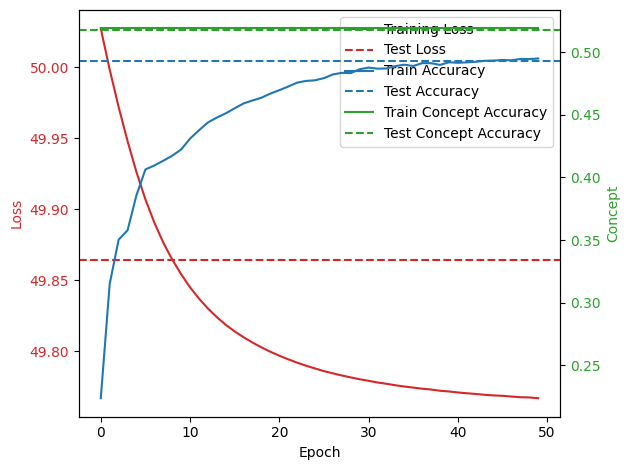

In [8]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1_train_loss = ax1.plot(range(len(losses)), losses, color=color, label="Training Loss")
ax1_test_loss = ax1.axhline(y = test_loss, color = color, linestyle = 'dashed', label="Test Loss") 
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2_train_accuracy = ax2.plot(range(len(accuracies)), accuracies, color=color, label="Train Accuracy")
ax2_test_accuracy = ax2.axhline(y = test_accuracy, color = color, linestyle = 'dashed', label="Test Accuracy") 
ax2.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  # instantiate a third Axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Concept', color=color)  # we already handled the x-label with ax1
ax2_train_concept_accuracy = ax2.plot(range(len(concept_accuracy)), concept_accuracy, color=color, label="Train Concept Accuracy")
ax2_test_concept_accuracy = ax2.axhline(y = test_concept_accuracy, color = color, linestyle = 'dashed', label="Test Concept Accuracy") 
ax2.tick_params(axis='y', labelcolor=color)

plots = ax1_train_loss+[ax1_test_loss]+ax2_train_accuracy+[ax2_test_accuracy]+ax2_train_concept_accuracy+[ax2_test_concept_accuracy]
labs = [l.get_label() for l in plots]
ax1.legend(plots, labs)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()